# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [74]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [75]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [76]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.arange(4.5e-8, 6e-8, 1e-9)
regularization_strengths = [4e5, 4.5e5, 5e5, 5.5e5]

results = {}
best_val = -1
best_svm = None
best_lr = None
best_reg = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for lr, reg in grid_search:
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
             num_iters=400)
    
    train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(train_pred == y_train)
    val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(val_pred == y_val)
    
    print("LR: %e | Reg: %e | Train: %f | Val: %f" % (lr, reg, train_acc, val_acc))
    
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
        best_lr = lr
        best_reg = reg
        
print("\n*******************************************************************************\n")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best learning rate: %e' % best_lr)
print('best regularization strength: %e' % best_reg)

LR: 4.500000e-08 | Reg: 4.000000e+05 | Train: 0.341755 | Val: 0.314000
LR: 4.500000e-08 | Reg: 4.500000e+05 | Train: 0.391041 | Val: 0.397000
LR: 4.500000e-08 | Reg: 5.000000e+05 | Train: 0.406204 | Val: 0.382000
LR: 4.500000e-08 | Reg: 5.500000e+05 | Train: 0.406102 | Val: 0.404000
LR: 4.600000e-08 | Reg: 4.000000e+05 | Train: 0.354653 | Val: 0.353000
LR: 4.600000e-08 | Reg: 4.500000e+05 | Train: 0.396898 | Val: 0.388000
LR: 4.600000e-08 | Reg: 5.000000e+05 | Train: 0.414612 | Val: 0.415000
LR: 4.600000e-08 | Reg: 5.500000e+05 | Train: 0.409959 | Val: 0.405000
LR: 4.700000e-08 | Reg: 4.000000e+05 | Train: 0.378347 | Val: 0.356000
LR: 4.700000e-08 | Reg: 4.500000e+05 | Train: 0.403776 | Val: 0.403000
LR: 4.700000e-08 | Reg: 5.000000e+05 | Train: 0.407327 | Val: 0.409000
LR: 4.700000e-08 | Reg: 5.500000e+05 | Train: 0.412102 | Val: 0.419000
LR: 4.800000e-08 | Reg: 4.000000e+05 | Train: 0.382122 | Val: 0.375000
LR: 4.800000e-08 | Reg: 4.500000e+05 | Train: 0.405612 | Val: 0.406000
LR: 4.

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.412


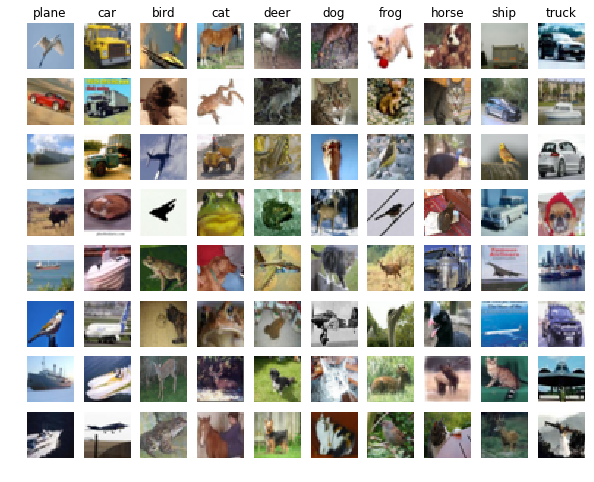

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
Yes, they make some sense. The objedcts in the misclassified images are in positions and have colors that normally indicate the class that the svm gave it. 



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [77]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [79]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None
best_val = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# 1st try - success
# def generate_random_hyperparameters(lr_min, lr_max, reg_min, reg_max, hsize_min, hsize_max):
#     # lr = 10**np.random.uniform(lr_min, lr_max)
#     lr = np.random.uniform(lr_min, lr_max)
#     # reg = 10**np.random.uniform(reg_min, reg_max)
#     reg = np.random.uniform(reg_min, reg_max)
#     hsize = np.random.randint(hsize_min, hsize_max)
#     return lr, reg, hsize
    
# for _ in range(10):
#     lr, reg, hsize = generate_random_hyperparameters(7e-1, 4e-1, 5e-8, 2e-8, 300, 800)
    
#     net = TwoLayerNet(input_dim, hsize, num_classes)
#     stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
#                      learning_rate=lr, reg=reg, num_iters=2000)
    
#     train_pred = net.predict(X_train_feats)
#     train_acc = np.mean(train_pred == y_train)
#     val_pred = net.predict(X_val_feats)
#     val_acc = np.mean(val_pred == y_val)
    
#     if val_acc > best_val:
#         best_val = val_acc
#         best_net = net
        
        
#     print("LR: %e | Reg: %e | Hsize: %d | Train: %f | Val: %f" % (lr, reg, hsize, train_acc, val_acc))

# 2nd try - success
def generate_random_hyperparameters(lr_min, lr_max, reg_min, reg_max, hsize_min, hsize_max):
    # lr = 10**np.random.uniform(lr_min, lr_max)
    lr = np.random.uniform(lr_min, lr_max)
    reg = 10**np.random.uniform(reg_min, reg_max)
    # reg = np.random.uniform(reg_min, reg_max)
    hsize = np.random.randint(hsize_min, hsize_max)
    return lr, reg, hsize

for _ in range(5):
    lr, reg, hsize = generate_random_hyperparameters(8e-1, 9e-1, -5, -4, 371, 450)
    
    net = TwoLayerNet(input_dim, hsize, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                     learning_rate=lr, reg=reg, num_iters=2500)
    
    train_pred = net.predict(X_train_feats)
    train_acc = np.mean(train_pred == y_train)
    val_pred = net.predict(X_val_feats)
    val_acc = np.mean(val_pred == y_val)
    
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        
        
    print("LR: %e | Reg: %e | Hsize: %d | Train: %f | Val: %f" % (lr, reg, hsize, train_acc, val_acc))
        
print("\n*******************************************************************************\n")

print('best validation accuracy achieved during cross-validation: %f' % best_val)
        
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


LR: 8.623584e-01 | Reg: 1.758221e-05 | Hsize: 411 | Train: 0.785204 | Val: 0.571000
LR: 8.911518e-01 | Reg: 5.823216e-05 | Hsize: 427 | Train: 0.789041 | Val: 0.562000
LR: 8.798056e-01 | Reg: 7.154095e-05 | Hsize: 400 | Train: 0.785490 | Val: 0.591000
LR: 8.885385e-01 | Reg: 1.154515e-05 | Hsize: 430 | Train: 0.792408 | Val: 0.554000
LR: 8.788818e-01 | Reg: 6.590515e-05 | Hsize: 430 | Train: 0.792776 | Val: 0.575000
LR: 8.870633e-01 | Reg: 2.898757e-05 | Hsize: 439 | Train: 0.786510 | Val: 0.571000


KeyboardInterrupt: 

Dear future Max,

The leading hypothesis/technique for choosing hyperparameters is as follows:
    use random search. Choose a really large range (a ranger larger than you think is necessary or viable) and run the random search. Narrow the range as you start to see some high accuracies. If you don't see high accuracies, widen the range or run the random search longer. Pattern goes as follows ---> choose really wide range, run random search, narrow the range slowly based on the values with best results, repeat. Don't try to do random search with discrete values at first. Use ranges, so all you have to do is define a really small minimum and a really large maximum.
    
   That probably didn't make a whole lot of sense, so let me explain. Random search is when you make a range of possible values (i.e. a range between a really small minimum value and a really large maximum value) for each hyperparameters. Then random values are then randomly paired with the other hyperparameters. The hyperparameters are then evaluated to determine which values have the best accuracy. After you run the random serach long enough, you will notice that some combinations of hyperparameters give higher accuracies than others. Figure out which hyperparameters work best and narrow the range of possible values for each  hyperparameter to better fit the values with the best accuracies. Repeat until the range is really small, and high accuracies are achieved. (With larger ranges, use less iterations. As the range decreases, start to use larger iterations.) (As of writing this, I used around 500 iterations for the beginning ranges, and when I was sure of a really small range, I increased the iterations to 2500.) 
   
   For example, imagine you are trying to choose a hyperparameters. Maybe start with a really large range of 0 - 100. (The 0 - 100 range is arbitrary and easier to explain.) When the random search is run, you might find that the values 45, 56, and 61 have the best accuracies. Now, start to narrow the search. Change the range to 40 - 60 and repeat. Eventually, you will find that the values 57, 58, and 59 have the best accuracies. Once again, rerun the random search with a range of 57 - 59 (or maybe forget the random search and explicitly create multiple neural network iterations and test each discrete value i.e. test 57, 58, 59 instead of making a range). But this time, since the range of values is so small, use more iterations. Maybe use 1500 iterations instead of just 400. (You have to narrow the range of possible values for each hyperparameter together. So as you are narrowing the 0 - 100 range, you should also narrow the 0.1 - 1.0 range.) 
   
   This will become more complicated with more hyperparameters. The best advice is be patient. Maybe if you don't find the best hyperparameters on the first try widen your range or run the random search for longer. You'll find the best hyperparameters eventually. The best hyperparameter values might be a lot larger or a lot smaller than you expect. Keep an open mind and range.
   
   Good luck.
   Hopefully you will never have to read this.
   
   From, 
   past Max
   
   P.S. In the code above, the "generate_random_hyperparameters" generated a random value for each hyperparameter within a range of a really small minimum value and a really large maximum value at first. (When I mean really large range, I mean a really large range. For the learning rate, I started with a min value of 1e-15 and a max value of 0.) I used the for loop to look at many different combinations of hyperparameters. After I saw few combinations of good accuracies, I narrowed the range by making the min and max values closer to the hyperparameter values with the best accuracies.

In [80]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.59
